In [ ]:
import os
import csv

# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/DermatoAI/SeturiDateFinaleClasificareBoliPiele/Dataset-agumentat-mediu-undersampling/metadata.csv'

# Directory where your images are stored
image_directory = '/content/drive/MyDrive/DermatoAI/SeturiDateFinaleClasificareBoliPiele/Dataset-agumentat-mediu-undersampling/dataset'

missing_files = []
i = 0
# Assuming your CSV has headers and 'isic_id' is the column with image filenames
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        isic_id = row['isic_id']  # Adjust the key if your column name is different
        image_path = os.path.join(image_directory, f"{isic_id}")  # Adjust extension if needed
        if not os.path.exists(image_path):
            missing_files.append(isic_id)

# Print the number of missing files and some examples
print(f"Total missing files: {len(missing_files)}")
if len(missing_files) > 0:
    print("Examples of missing files:", missing_files[:10])



Total missing files: 0


In [35]:
!cp -r "/content/drive/MyDrive/DermatoAI/SetDateClasificareBinaraPiele" "/content/sample_data"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/DermatoAI/SetClasificareBoliBalanced.zip" -d "/content/drive/MyDrive/DermatoAI"


In [37]:
import os

def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files
print(count_files('/content/sample_data/SetDateClasificareBinaraPiele'))

5918


Found 4143 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.
{'healthy': 0, 'unhealthy': 1}
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_826 (Conv2D)         (None, 450, 600, 16)      448       
                                                                 
 batch_normalization_867 (B  (None, 450, 600, 16)      64        
 atchNormalization)                                              
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 225, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_827 (Conv2D)         (None, 225, 300, 32)      4640      
                                                                 
 batch_normalization_868 (B  (None, 225, 300, 32)      128       
 atch

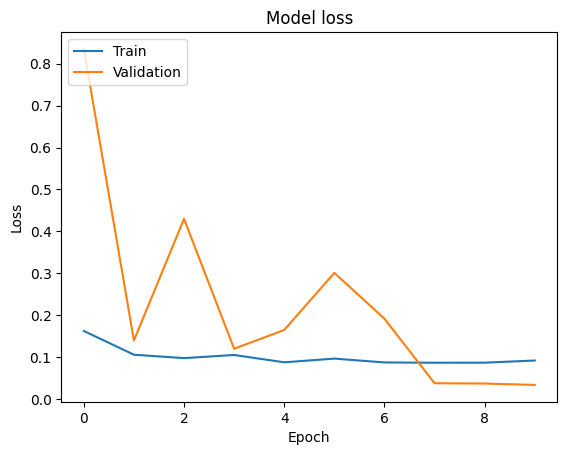

111/111 [==============================] - 45s 406ms/step


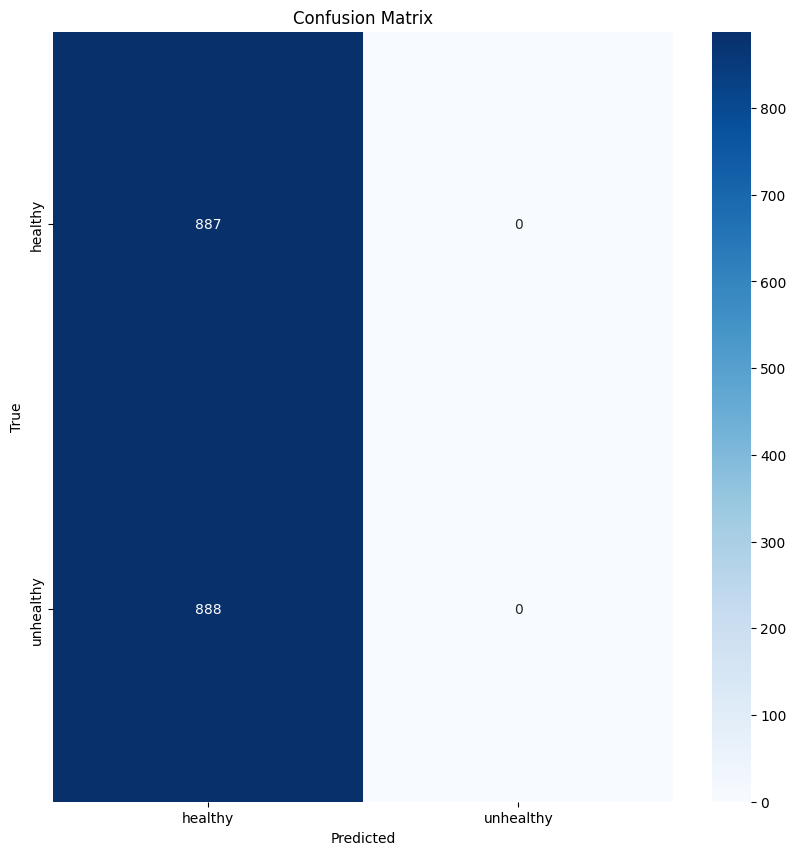

              precision    recall  f1-score   support

     healthy       0.50      1.00      0.67       887
   unhealthy       0.00      0.00      0.00       888

    accuracy                           0.50      1775
   macro avg       0.25      0.50      0.33      1775
weighted avg       0.25      0.50      0.33      1775



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/trainin

In [40]:
import pandas as pd
import tensorflow as tf
from keras.src.layers import Flatten
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Dense, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

np.random.seed(42)
target_size = (450, 600)
batch = 16
epochs = 10

image_directory = '/content/sample_data/SetDateClasificareBinaraPiele'

datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)  # 20% data for validation

train_generator = datagen.flow_from_directory(
    directory=image_directory,
    target_size=target_size,
    batch_size=batch,
    shuffle=True,
    class_mode='binary',  # Change to 'binary' for binary classification
    subset='training',
    seed=42
)

validation_generator = datagen.flow_from_directory(
    directory=image_directory,
    target_size=target_size,
    batch_size=batch,
    shuffle=False,
    class_mode='binary',  # Change to 'binary' for binary classification
    subset='validation',
    seed=42
)

print(train_generator.class_indices)


model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0007),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()]
)





model.summary()


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss',min_delta=0.001, mode='min', patience=4, verbose=1, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    # class_weight=class_weights,
    epochs=epochs,
    callbacks=callbacks
)

validation_generator.reset()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict on the whole validation set
predictions = model.predict(validation_generator, steps=np.ceil(validation_generator.n / validation_generator.batch_size))

predicted_classes = (predictions > 0.5).astype(int).flatten()

# Retrieve the true class indices assigned by the generator
true_classes = validation_generator.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Save the model
model.save('/content/drive/MyDrive/DermatoAI/Models/Binary.h5')